In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [69]:
def load_dataframe(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [70]:
def component_split(x):
    x_split = str(x).split(",")

    for s in x_split:
        if "comp:" in s.lower():
            return s.strip()
    return None

In [71]:
def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame, minimum_contribution = 100) -> pd.DataFrame:
    developers = df["assignees"].value_counts()
    filtered_developers = developers.index[developers >= minimum_contribution]
    df = df[df["assignees"].isin(filtered_developers)]

    df["text"] = df.apply(lambda x: str(x["issue_title"]) + "\n" + str(x["issue_body"]), axis=1)
    df = df[df["labels"].notna()]
    df["component"] = df["labels"].apply(component_split)

    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    return df

/tmp/ipykernel_3264249/2075464382.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df.apply(lambda x: str(x["issue_title"]) + "\n" + str(x["issue_body"]), axis=1)


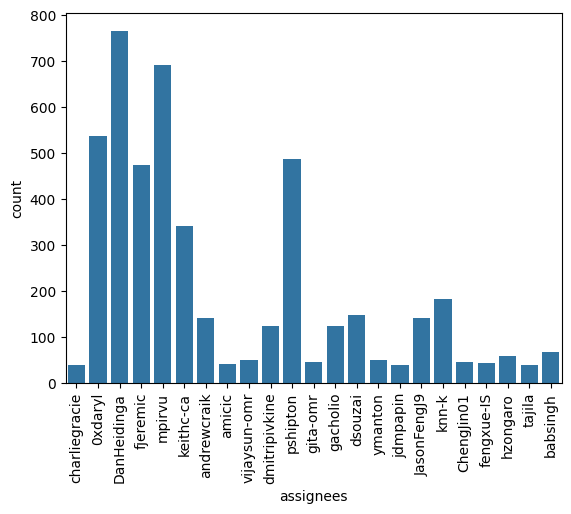

In [72]:
data_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/merged.csv"

df = load_dataframe(data_path)
df = prepare_dataframe(df, 40)
df = clean_data(df)

fig = sns.countplot(x = "assignees", data=df)
for item in fig.get_xticklabels():
    item.set_rotation(90)

In [73]:
components = set()

In [74]:
sum(df["component"].isna())

175

In [75]:
for val in df["component"].values:
    if val is None:
        continue
    
    split = val.split(",")
    
    for s in split:
        components.add(s.strip())

In [76]:
components

{'comp:build',
 'comp:crypto',
 'comp:doc',
 'comp:gc',
 'comp:infra',
 'comp:jclextensions',
 'comp:jit',
 'comp:jit:aot',
 'comp:jitserver',
 'comp:jvmti',
 'comp:port',
 'comp:test',
 'comp:vm'}

In [77]:
df["component"].value_counts()

component
comp:jit              1678
comp:vm               1442
comp:jitserver         583
comp:build             366
comp:gc                192
comp:test              142
comp:doc                70
comp:jit:aot            15
comp:port               10
comp:jclextensions       6
comp:jvmti               4
comp:infra               2
comp:crypto              1
Name: count, dtype: int64

In [78]:
component_values = df["component"].value_counts()
filtered_components = component_values.index[component_values >= 50]

df = df[df["component"].isin(filtered_components)]

In [79]:
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=22),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

3578 447 448


/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [80]:
import torch.nn as nn
from transformers import RobertaModel, RobertaTokenizer
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, model_name: str, output_size, embed_size, dropout = 0.1) -> None:
        super().__init__()
        self.base_model = RobertaModel.from_pretrained(model_name, output_hidden_states=True)
        filter_sizes = [3, 4, 5, 6]
        num_filters = 256
        self._tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.convs1 = nn.ModuleList([nn.Conv2d(4, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, output_size)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids, attention_mask = attention_mask)[2][-4:]
        x = torch.stack(x, dim=1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc1(x)  

        return self.relu(logit)
    
    def tokenizer(self) -> RobertaTokenizer:
        return self._tokenizer

In [81]:
label2idx = {label: idx for idx, label in enumerate(list(df["component"].unique()))}

In [82]:
label2idx

{'comp:doc': 0,
 'comp:jit': 1,
 'comp:vm': 2,
 'comp:build': 3,
 'comp:gc': 4,
 'comp:test': 5,
 'comp:jitserver': 6}

In [83]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, label_column):
        self.tokenizer = tokenizer
        self.labels = [label2idx[label] for label in df[label_column]]
        self.texts = [self.tokenizer(text,
                               padding='max_length', max_length = 500, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [84]:
from torch.optim import Adam
from tqdm import tqdm

In [85]:
def train(model, tokenizer, train_data, val_data, learning_rate, epochs, out_file):
    label_column = "component"
    train, val = Dataset(train_data, tokenizer, label_column=label_column), Dataset(val_data, tokenizer, label_column=label_column)
    batch_size = 20

    train_dataloader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=True
    )
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    best_loss = float("inf")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_epoch_loss = []
    train_epoch_acc = []
    val_epoch_loss = []
    val_epoch_acc = []

    if use_cuda:
        print("Using CUDA...")
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input["attention_mask"].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input["attention_mask"].to(device)
                input_id = val_input["input_ids"].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        
        train_loss = total_loss_train / len(train_data)
        val_loss = total_loss_val / len(val_data)

        train_acc = total_acc_train / len(train_data)
        val_acc = total_acc_val / len(val_data)

        train_epoch_loss.append(train_loss)
        val_epoch_loss.append(val_loss)
        train_epoch_acc.append(train_acc)
        val_epoch_acc.append(val_acc)

        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}"
        print(log)

        if val_loss < best_loss:
            print("Found new best model. Saving weights...")
            torch.save(model.state_dict(), out_file)
            best_loss = val_loss


In [86]:
EPOCHS = 20
num_classes = len(df["component"].unique())
model = Classifier("roberta-base", num_classes, 768)
tokenizer = model.tokenizer()
LR = 1e-6

train(model, tokenizer, df_train, df_val, LR, EPOCHS, "component_predictor_cleaned.pt")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using CUDA...
Epoch: 0


100%|██████████| 179/179 [01:20<00:00,  2.23it/s]


Epochs: 1 | Train Loss:  0.088                 | Train Accuracy:  0.333                 | Val Loss:  0.075                 | Val Accuracy:  0.445
Found new best model. Saving weights...
Epoch: 1


100%|██████████| 179/179 [01:20<00:00,  2.22it/s]


Epochs: 2 | Train Loss:  0.068                 | Train Accuracy:  0.530                 | Val Loss:  0.065                 | Val Accuracy:  0.604
Found new best model. Saving weights...
Epoch: 2


100%|██████████| 179/179 [01:20<00:00,  2.22it/s]


Epochs: 3 | Train Loss:  0.058                 | Train Accuracy:  0.634                 | Val Loss:  0.056                 | Val Accuracy:  0.676
Found new best model. Saving weights...
Epoch: 3


100%|██████████| 179/179 [01:20<00:00,  2.22it/s]


Epochs: 4 | Train Loss:  0.050                 | Train Accuracy:  0.701                 | Val Loss:  0.050                 | Val Accuracy:  0.705
Found new best model. Saving weights...
Epoch: 4


100%|██████████| 179/179 [01:20<00:00,  2.22it/s]


Epochs: 5 | Train Loss:  0.043                 | Train Accuracy:  0.749                 | Val Loss:  0.045                 | Val Accuracy:  0.738
Found new best model. Saving weights...
Epoch: 5


 59%|█████▊    | 105/179 [00:47<00:33,  2.21it/s]

In [ ]:
import random

idx2label = { idx: label for idx, label in enumerate(label2idx)}

for i in range(5):
    rand = random.randint(0, len(df_test))
    dx = df_test.iloc[rand]

    data = model.tokenizer()(dx["text"])
    ids, mask = data["input_ids"], data["attention_mask"]

    id = torch.tensor([ids]).cuda()
    m = torch.tensor([mask]).cuda()

    g = nn.Softmax(dim=1)

    print(dx["component"], idx2label[int(torch.argmax(g(model(id, m))).cpu().numpy())])

comp:build comp:build
comp:jit comp:jit
comp:jitserver comp:jitserver
comp:jit comp:jit
comp:vm comp:vm
